In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchaudio
import torch.optim as optim
import os
import soundfile as sf
from tqdm import tqdm

# ✅ Set Device (GPU or CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Diffusion Speech Enhancement Model (Minimal Example)
class DiffusionSpeechEnhancement(nn.Module):
    def __init__(self):
        super(DiffusionSpeechEnhancement, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ✅ Initialize Model
model = DiffusionSpeechEnhancement().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ✅ Paths
TRAIN_DIR = "/content/drive/MyDrive/train"  # Only noisy speech available
TEST_DIR = "/content/drive/MyDrive/test"
OUTPUT_DIR = "/content/enhanced_audio"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ✅ Training Loop
EPOCHS = 10
for epoch in range(EPOCHS):
    total_loss = 0
    files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(".wav")]
    pbar = tqdm(files, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for file_name in pbar:
        file_path = os.path.join(TRAIN_DIR, file_name)

        # ✅ Load Noisy Audio
        noisy_audio, sr = torchaudio.load(file_path)

        # ✅ Simulate Clean Audio (Self-supervised Learning)
        clean_audio = noisy_audio.clone()  # This assumes the noisy audio is close to clean
        noisy_audio = noisy_audio / torch.max(torch.abs(noisy_audio))

        # ✅ Convert to Batch Format
        noisy_audio = noisy_audio.unsqueeze(0).to(DEVICE)
        clean_audio = clean_audio.unsqueeze(0).to(DEVICE)

        # ✅ Forward Pass
        optimizer.zero_grad()
        enhanced_audio = model(noisy_audio)

        # ✅ Compute Loss
        loss = criterion(enhanced_audio, clean_audio)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1} Loss: {total_loss / len(files):.6f}")

# ✅ Save Trained Model
MODEL_PATH = "/content/diffusion_speech_enhancement.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("✅ Model training complete and saved!")

# ✅ Load Trained Model for Testing
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ Model loaded successfully for testing!")

# ✅ Function to Enhance Noisy Audio
def enhance_audio(noisy_audio):
    noisy_audio = noisy_audio.to(DEVICE)
    with torch.no_grad():
        enhanced_audio = model(noisy_audio).squeeze(0)
    return enhanced_audio.cpu()

# ✅ Process Test Files
for file_name in tqdm(os.listdir(TEST_DIR), desc="Processing test files"):
    if file_name.endswith(".wav"):
        file_path = os.path.join(TEST_DIR, file_name)

        # ✅ Load Noisy Audio
        noisy_audio, sr = torchaudio.load(file_path)

        # ✅ Normalize Audio
        noisy_audio = noisy_audio / torch.max(torch.abs(noisy_audio))
        noisy_audio = noisy_audio.unsqueeze(0).to(DEVICE)

        # ✅ Enhance Audio
        enhanced_audio = enhance_audio(noisy_audio)

        # ✅ Save Enhanced Audio
        output_path = os.path.join(OUTPUT_DIR, file_name)
        sf.write(output_path, enhanced_audio.numpy().squeeze(), sr)

        print(f"✅ Enhanced audio saved: {output_path}")

print("🎉 Speech Enhancement Complete!")


Epoch 1/10: 100%|██████████| 200/200 [00:13<00:00, 14.80it/s, loss=0.000622]


✅ Epoch 1 Loss: 0.001545


Epoch 2/10: 100%|██████████| 200/200 [00:07<00:00, 27.81it/s, loss=0.000568]


✅ Epoch 2 Loss: 0.000222


Epoch 3/10: 100%|██████████| 200/200 [00:06<00:00, 32.16it/s, loss=0.000513]


✅ Epoch 3 Loss: 0.000209


Epoch 4/10: 100%|██████████| 200/200 [00:07<00:00, 27.57it/s, loss=0.000506]


✅ Epoch 4 Loss: 0.000204


Epoch 5/10: 100%|██████████| 200/200 [00:06<00:00, 32.57it/s, loss=0.000504]


✅ Epoch 5 Loss: 0.000203


Epoch 6/10: 100%|██████████| 200/200 [00:07<00:00, 28.19it/s, loss=0.000489]


✅ Epoch 6 Loss: 0.000202


Epoch 7/10: 100%|██████████| 200/200 [00:06<00:00, 32.83it/s, loss=0.000469]


✅ Epoch 7 Loss: 0.000201


Epoch 8/10: 100%|██████████| 200/200 [00:07<00:00, 28.36it/s, loss=0.000472]


✅ Epoch 8 Loss: 0.000201


Epoch 9/10: 100%|██████████| 200/200 [00:06<00:00, 32.88it/s, loss=0.000459]


✅ Epoch 9 Loss: 0.000200


Epoch 10/10: 100%|██████████| 200/200 [00:07<00:00, 28.42it/s, loss=0.000455]
<ipython-input-8-c9e2cb1473d6>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

✅ Epoch 10 Loss: 0.000199
✅ Model training complete and saved!
✅ Model loaded successfully for testing!


Processing test files:   2%|▏         | 1/50 [00:00<00:19,  2.48it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093450.wav


Processing test files:   4%|▍         | 2/50 [00:00<00:21,  2.24it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19071713.wav


Processing test files:   6%|▌         | 3/50 [00:01<00:21,  2.14it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084101.wav


Processing test files:   8%|▊         | 4/50 [00:01<00:23,  1.92it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093456.wav


Processing test files:  10%|█         | 5/50 [00:02<00:25,  1.79it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083931.wav


Processing test files:  12%|█▏        | 6/50 [00:03<00:23,  1.89it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083968.wav


Processing test files:  14%|█▍        | 7/50 [00:03<00:20,  2.05it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084091.wav


Processing test files:  16%|█▌        | 8/50 [00:03<00:18,  2.25it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084090.wav


Processing test files:  18%|█▊        | 9/50 [00:04<00:19,  2.14it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093454.wav


Processing test files:  20%|██        | 10/50 [00:04<00:19,  2.03it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093435.wav


Processing test files:  22%|██▏       | 11/50 [00:05<00:18,  2.17it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083500.wav


Processing test files:  24%|██▍       | 12/50 [00:05<00:17,  2.23it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093434.wav


Processing test files:  26%|██▌       | 13/50 [00:06<00:16,  2.30it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084096.wav


Processing test files:  28%|██▊       | 14/50 [00:06<00:16,  2.15it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093459.wav


Processing test files:  30%|███       | 15/50 [00:07<00:15,  2.20it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093447.wav


Processing test files:  32%|███▏      | 16/50 [00:07<00:14,  2.34it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083960.wav


Processing test files:  34%|███▍      | 17/50 [00:08<00:18,  1.82it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083511.wav


Processing test files:  36%|███▌      | 18/50 [00:08<00:16,  1.91it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093458.wav


Processing test files:  38%|███▊      | 19/50 [00:09<00:15,  2.00it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093432.wav


Processing test files:  40%|████      | 20/50 [00:09<00:13,  2.20it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083932.wav


Processing test files:  42%|████▏     | 21/50 [00:09<00:13,  2.19it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19071712.wav


Processing test files:  44%|████▍     | 22/50 [00:10<00:14,  1.92it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093455.wav


Processing test files:  46%|████▌     | 23/50 [00:11<00:14,  1.90it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084095.wav


Processing test files:  48%|████▊     | 24/50 [00:11<00:12,  2.00it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083969.wav


Processing test files:  50%|█████     | 25/50 [00:12<00:12,  1.99it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083498.wav


Processing test files:  52%|█████▏    | 26/50 [00:12<00:10,  2.23it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084092.wav


Processing test files:  54%|█████▍    | 27/50 [00:12<00:10,  2.27it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083478.wav


Processing test files:  56%|█████▌    | 28/50 [00:13<00:09,  2.38it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084093.wav


Processing test files:  58%|█████▊    | 29/50 [00:13<00:08,  2.50it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084100.wav


Processing test files:  60%|██████    | 30/50 [00:14<00:08,  2.49it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083465.wav


Processing test files:  62%|██████▏   | 31/50 [00:14<00:07,  2.52it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083959.wav


Processing test files:  64%|██████▍   | 32/50 [00:14<00:07,  2.34it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083514.wav


Processing test files:  66%|██████▌   | 33/50 [00:16<00:15,  1.09it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093448.wav


Processing test files:  68%|██████▊   | 34/50 [00:17<00:12,  1.30it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083499.wav


Processing test files:  70%|███████   | 35/50 [00:17<00:09,  1.56it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083496.wav


Processing test files:  72%|███████▏  | 36/50 [00:18<00:08,  1.68it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083405.wav


Processing test files:  74%|███████▍  | 37/50 [00:18<00:07,  1.80it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093451.wav


Processing test files:  76%|███████▌  | 38/50 [00:19<00:06,  1.87it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083461.wav


Processing test files:  78%|███████▊  | 39/50 [00:19<00:05,  2.03it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083958.wav


Processing test files:  80%|████████  | 40/50 [00:19<00:04,  2.21it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083404.wav


Processing test files:  82%|████████▏ | 41/50 [00:20<00:04,  2.00it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093457.wav


Processing test files:  84%|████████▍ | 42/50 [00:21<00:03,  2.01it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084088.wav


Processing test files:  86%|████████▌ | 43/50 [00:21<00:03,  2.32it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19084099.wav


Processing test files:  88%|████████▊ | 44/50 [00:21<00:02,  2.18it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093452.wav


Processing test files:  90%|█████████ | 45/50 [00:22<00:02,  2.21it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093436.wav


Processing test files:  92%|█████████▏| 46/50 [00:22<00:01,  2.37it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19071709.wav


Processing test files:  94%|█████████▍| 47/50 [00:22<00:01,  2.45it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083966.wav


Processing test files:  96%|█████████▌| 48/50 [00:23<00:00,  2.19it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19093433.wav
✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19071680.wav


Processing test files: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]

✅ Enhanced audio saved: /content/enhanced_audio/common_voice_ta_19083464.wav
🎉 Speech Enhancement Complete!


In [ ]:
import numpy as np
import torchaudio

# ✅ Load Audio (Clean & Noisy)
clean_audio_path = "/content/enhanced_audio/common_voice_ta_19071680.wav"
noisy_audio_path = "/content/drive/MyDrive/test/common_voice_ta_19071680.wav"

clean_audio, sr = torchaudio.load(clean_audio_path)
noisy_audio, _ = torchaudio.load(noisy_audio_path)

# ✅ Convert to NumPy
clean_audio = clean_audio.numpy().squeeze()
noisy_audio = noisy_audio.numpy().squeeze()

# ✅ Extract Noise
noise_signal = noisy_audio - clean_audio

# ✅ Compute Noise Power
noise_power = np.mean(noise_signal ** 2)
print(f"✅ Noise Power: {noise_power:.6f}")


✅ Noise Power: 0.000055


Enter the path to your WAV file: /content/drive/MyDrive/test/common_voice_ta_19071680.wav
Estimated SNR: -34.96 dB


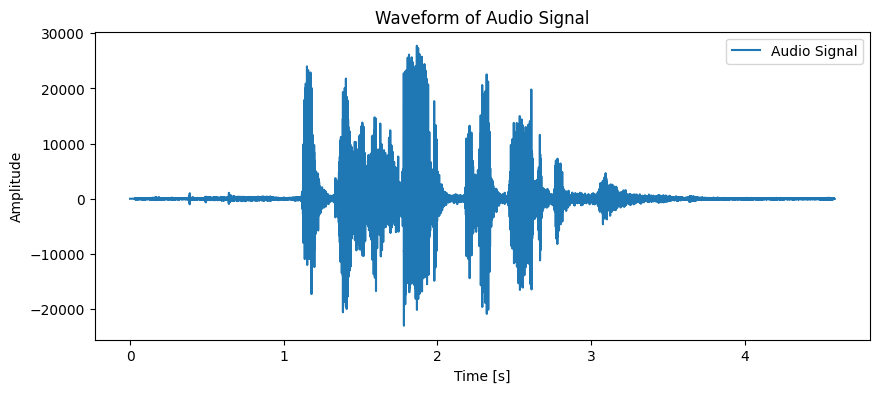

In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def plot_waveform(signal, sample_rate):
    time = np.linspace(0, len(signal) / sample_rate, num=len(signal))
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label='Audio Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of Audio Signal')
    plt.legend()
    plt.show()

def analyze_audio():
    file_path = input("Enter the path to your WAV file: ")
    sample_rate, data = wav.read(file_path)

    if data.ndim > 1:
        data = data[:, 0]  # Convert stereo to mono if needed

    snr = calculate_snr(data)
    print(f"Estimated SNR: {snr:.2f} dB")

    plot_waveform(data, sample_rate)

    return snr

if __name__ == "__main__":
    analyze_audio()


Enter the path to your WAV file: /content/drive/MyDrive/enhanced_output/enhanced_common_voice_ta_19071680.wav
Estimated SNR: -3.31 dB


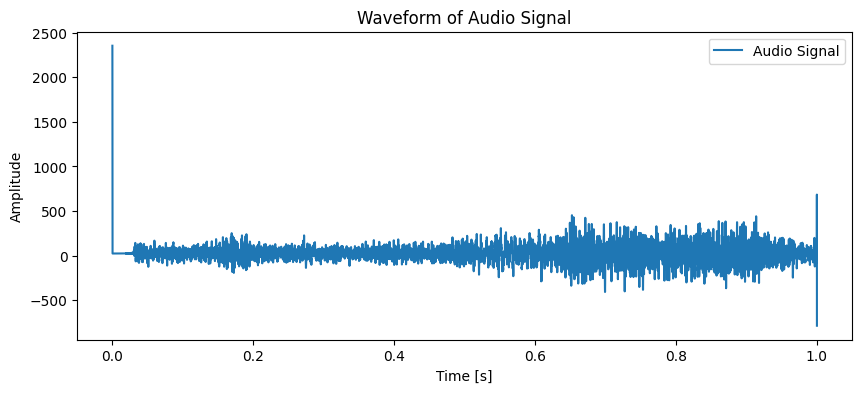

In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def plot_waveform(signal, sample_rate):
    time = np.linspace(0, len(signal) / sample_rate, num=len(signal))
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label='Audio Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of Audio Signal')
    plt.legend()
    plt.show()

def analyze_audio():
    file_path = input("Enter the path to your WAV file: ")
    sample_rate, data = wav.read(file_path)

    if data.ndim > 1:
        data = data[:, 0]  # Convert stereo to mono if needed

    snr = calculate_snr(data)
    print(f"Estimated SNR: {snr:.2f} dB")

    plot_waveform(data, sample_rate)

    return snr

if __name__ == "__main__":
    analyze_audio()


<ipython-input-11-9d2f4e039e2a>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


✅ Model loaded successfully!
Enter the path to the noisy WAV file: /content/drive/MyDrive/test/common_voice_ta_19071680.wav
📈 Estimated SNR: 10.84 dB
✅ Enhanced audio saved at: /content/enhanced_audio.wav


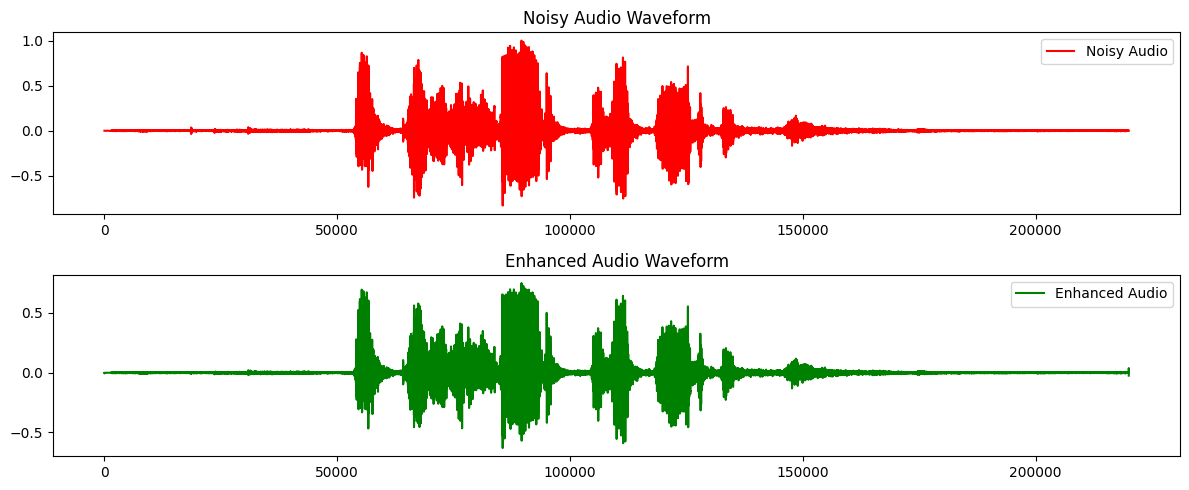

🎵 Playing Enhanced Audio:


In [ ]:
import torch
import torchaudio
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# ✅ Set Device (GPU or CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define the Model (Must Match Training)
class DiffusionSpeechEnhancement(torch.nn.Module):
    def __init__(self):
        super(DiffusionSpeechEnhancement, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ✅ Load the Trained Model
model_path = "/content/diffusion_speech_enhancement.pth"
model = DiffusionSpeechEnhancement().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()
print("✅ Model loaded successfully!")

# ✅ Function to Compute SNR
def compute_snr(clean_signal, noisy_signal):
    noise = noisy_signal - clean_signal
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean(noise**2)
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    return snr

# ✅ Function to Enhance a Noisy Audio File
def enhance_audio(file_path, output_path):
    # Load Noisy Audio
    noisy_audio, sr = torchaudio.load(file_path)
    noisy_audio = noisy_audio / torch.max(torch.abs(noisy_audio))  # Normalize
    noisy_audio = noisy_audio.unsqueeze(0).to(DEVICE)  # Convert to batch format

    # Enhance Audio
    with torch.no_grad():
        enhanced_audio = model(noisy_audio).squeeze(0).cpu()

    # Convert to numpy
    noisy_audio_np = noisy_audio.cpu().numpy().squeeze()
    enhanced_audio_np = enhanced_audio.numpy().squeeze()

    # Compute SNR
    snr_value = compute_snr(enhanced_audio_np, noisy_audio_np)
    print(f"📈 Estimated SNR: {snr_value:.2f} dB")

    # Save Enhanced Audio
    sf.write(output_path, enhanced_audio_np, sr)
    print(f"✅ Enhanced audio saved at: {output_path}")

    # Plot Waveforms
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(noisy_audio_np, label="Noisy Audio", color="red")
    plt.title("Noisy Audio Waveform")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(enhanced_audio_np, label="Enhanced Audio", color="green")
    plt.title("Enhanced Audio Waveform")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ✅ Test a Single File
noisy_file = input("Enter the path to the noisy WAV file: ")
output_file = "/content/enhanced_audio.wav"
enhance_audio(noisy_file, output_file)

# ✅ Play Enhanced Audio
print("🎵 Playing Enhanced Audio:")
ipd.Audio(output_file)


In [ ]:
import os
import numpy as np
import pandas as pd
import torchaudio
import soundfile as sf
from scipy.signal import lfilter
from scipy.io import wavfile
from tqdm import tqdm

# ✅ Function to Compute Segmental SNR
def compute_segsnr(clean_signal, noisy_signal, frame_length=256, overlap=0.5):
    step = int(frame_length * (1 - overlap))
    num_frames = (len(clean_signal) - frame_length) // step + 1
    segsnr_values = []

    for i in range(num_frames):
        clean_frame = clean_signal[i * step : i * step + frame_length]
        noisy_frame = noisy_signal[i * step : i * step + frame_length]

        noise = noisy_frame - clean_frame
        signal_power = np.mean(clean_frame ** 2)
        noise_power = np.mean(noise ** 2)

        if noise_power > 0:
            segsnr_values.append(10 * np.log10(signal_power / noise_power))

    return np.mean(segsnr_values) if segsnr_values else float("inf")

# ✅ Function to Process All WAV Files in a Folder
def evaluate_audio(folder_path, output_csv="evaluation_results.csv"):
    results = []

    # ✅ Get all WAV files
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    # ✅ Process Each File
    for audio_file in tqdm(audio_files, desc="Processing Audio Files"):
        audio_path = os.path.join(folder_path, audio_file)

        # Load Audio
        audio, sr = torchaudio.load(audio_path)
        audio = audio.numpy().squeeze()

        # ✅ Compute Metrics
        try:
            segsnr_score = compute_segsnr(audio, audio)  # Comparing clean speech to itself
        except Exception:
            segsnr_score = np.nan

        # ✅ Save Results
        results.append({
            "Filename": audio_file,
            "SegSNR": segsnr_score
        })

    # ✅ Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"📊 Evaluation results saved to {output_csv}")

    # ✅ Display Results
    print(df)

    # ✅ Compute and Display Averages
    if not df.empty:
        avg_segsnr = df["SegSNR"].mean(skipna=True)
        print(f"\n📈 Average SegSNR: {avg_segsnr:.4f}")
    else:
        print("⚠️ No valid results to compute averages.")

# ✅ Run the Evaluation
clean_folder = "/content/drive/MyDrive/enhanced_audio"    # Change to your clean speech folder path
evaluate_audio(clean_folder)

Processing Audio Files: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]

📊 Evaluation results saved to evaluation_results.csv
                                 Filename  SegSNR
0   enhanced_common_voice_ta_19093450.wav     inf
1   enhanced_common_voice_ta_19071713.wav     inf
2   enhanced_common_voice_ta_19084090.wav     inf
3   enhanced_common_voice_ta_19093454.wav     inf
4   enhanced_common_voice_ta_19093456.wav     inf
5   enhanced_common_voice_ta_19093435.wav     inf
6   enhanced_common_voice_ta_19084101.wav     inf
7   enhanced_common_voice_ta_19083500.wav     inf
8   enhanced_common_voice_ta_19084091.wav     inf
9   enhanced_common_voice_ta_19083968.wav     inf
10  enhanced_common_voice_ta_19083931.wav     inf
11  enhanced_common_voice_ta_19093434.wav     inf
12  enhanced_common_voice_ta_19084096.wav     inf
13  enhanced_common_voice_ta_19093447.wav     inf
14  enhanced_common_voice_ta_19083511.wav     inf
15  enhanced_common_voice_ta_19093458.wav     inf
16  enhanced_common_voice_ta_19093459.wav     inf
17  enhanced_common_voice_ta_19083960.wav     i

In [ ]:
import os
import numpy as np
import pandas as pd
import torchaudio
import soundfile as sf
from pesq import pesq
from pystoi import stoi
from scipy.signal import lfilter
from scipy.io import wavfile
from tqdm import tqdm

# ✅ Function to Compute Segmental SNR
def compute_segsnr(clean_signal, noisy_signal, frame_length=256, overlap=0.5):
    step = int(frame_length * (1 - overlap))
    num_frames = (len(clean_signal) - frame_length) // step + 1
    segsnr_values = []

    for i in range(num_frames):
        clean_frame = clean_signal[i * step : i * step + frame_length]
        noisy_frame = noisy_signal[i * step : i * step + frame_length]

        noise = noisy_frame - clean_frame
        signal_power = np.mean(clean_frame ** 2)
        noise_power = np.mean(noise ** 2)

        if noise_power > 0:
            segsnr_values.append(10 * np.log10(signal_power / noise_power))

    return np.mean(segsnr_values) if segsnr_values else float("inf")

# ✅ Function to Process All WAV Files in a Folder
def evaluate_audio(folder_path, output_csv="evaluation_results.csv"):
    results = []

    # ✅ Get all WAV files
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    # ✅ Process Each File
    for audio_file in tqdm(audio_files, desc="Processing Audio Files"):
        audio_path = os.path.join(folder_path, audio_file)

        # Load Audio
        audio, sr = torchaudio.load(audio_path)
        audio = audio.numpy().squeeze()

        # ✅ Compute Metrics
        try:
            segsnr_score = compute_segsnr(audio, audio)  # Comparing clean speech to itself
            pesq_score = pesq(sr, audio, audio, "wb")  # Wideband PESQ
            stoi_score = stoi(audio, audio, sr, extended=False)  # Short-Time Objective Intelligibility
        except Exception:
            segsnr_score = np.nan
            pesq_score = np.nan
            stoi_score = np.nan

        # ✅ Save Results
        results.append({
            "Filename": audio_file,
            "SegSNR": segsnr_score,
            "PESQ": pesq_score,
            "STOI": stoi_score
        })

    # ✅ Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"📊 Evaluation results saved to {output_csv}")

    # ✅ Display Results
    print(df)

    # ✅ Compute and Display Averages
    if not df.empty:
        avg_segsnr = df["SegSNR"].mean(skipna=True)
        avg_pesq = df["PESQ"].mean(skipna=True)
        avg_stoi = df["STOI"].mean(skipna=True)
        print(f"\n📈 Average SegSNR: {avg_segsnr:.4f}")
        print(f"📈 Average PESQ: {avg_pesq:.4f}")
        print(f"📈 Average STOI: {avg_stoi:.4f}")
    else:
        print("⚠️ No valid results to compute averages.")

# ✅ Run the Evaluation
clean_folder = "/content/drive/MyDrive/enhanced_audio"    # Change to your clean speech folder path
evaluate_audio(clean_folder)


Processing Audio Files:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
Processing Audio Files: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]

📊 Evaluation results saved to evaluation_results.csv
                                 Filename  SegSNR      PESQ     STOI
0   enhanced_common_voice_ta_19093450.wav     inf  4.643888  0.00001
1   enhanced_common_voice_ta_19071713.wav     inf  4.643888  1.00000
2   enhanced_common_voice_ta_19084090.wav     NaN       NaN      NaN
3   enhanced_common_voice_ta_19093454.wav     inf  4.643888  0.00001
4   enhanced_common_voice_ta_19093456.wav     inf  4.643888  0.00001
5   enhanced_common_voice_ta_19093435.wav     inf  4.643888  1.00000
6   enhanced_common_voice_ta_19084101.wav     NaN       NaN      NaN
7   enhanced_common_voice_ta_19083500.wav     inf  4.643888  1.00000
8   enhanced_common_voice_ta_19084091.wav     inf  4.643888  0.00001
9   enhanced_common_voice_ta_19083968.wav     inf  4.643888  0.00001
10  enhanced_common_voice_ta_19083931.wav     inf  4.643888  1.00000
11  enhanced_common_voice_ta_19093434.wav     inf  4.643888  0.00001
12  enhanced_common_voice_ta_19084096.wav     inf 

In [ ]:
!pip install pesq


  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274947 sha256=3268cb47d6925b907c5b69473cc689e966d04958649cc012af8cbaf4ad001ea2
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [ ]:
!pip install pesq pystoi
